In [1]:
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, poisson
import numpy as np

# library specific settings

sns.set(color_codes=True)
pd.options.display.max_columns = 50

In [ ]:
# moving the parent folder to reach helpers
os.chdir('..')

# updating data
from helpers import update_data

# going back to the hw1 folder
os.chdir('hw1')

In [3]:
bets = pd.read_csv("../data/bets.zip")
booking = pd.read_csv("../data/booking.zip")
goals = pd.read_csv("../data/goals.zip")
matches = pd.read_csv("../data/matches.zip")
stats = pd.read_csv("../data/stats.zip")

In [4]:
bets.head()

,match_id,odd_bookmakers,odd_epoch,variable,value
0,146845,BetOlimp,1486301854,odd_1,1.96
1,151780,10Bet,1486314920,odd_1,2.15
2,151780,18bet,1486314920,odd_1,2.17
3,151780,1xBet,1486314920,odd_1,2.20
4,151780,5Dimes,1486314920,odd_1,2.23


In [5]:
matches.head()

,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
0,7109,7097,41196,1505559600,Finished,0,Levante,Valencia,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,468
1,2614,2619,13331,1505561400,Finished,0,Crystal Palace,Southampton,0.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,148
2,3224,3238,17683,1505568600,Finished,0,Eintracht Frankfurt,FC Augsburg,1.0,2.0,0.0,1.0,0.0,1.0,NaN,NaN,195
3,3235,3223,17684,1505568600,Finished,0,SV Werder Bremen,Schalke,1.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,195
4,3237,3225,17682,1505568600,Finished,0,Bayern Munich,1. FSV Mainz 05,4.0,0.0,2.0,0.0,2.0,0.0,NaN,NaN,195


## Data Cleaning

We need to subset our datasets to English Premiere League matches

In [13]:
#TODO league id's are correct now, no need to this cleaning

In [6]:
PREMIERE_LEAGUE_ID = 148
matches = matches[matches['league_id'] == PREMIERE_LEAGUE_ID].reset_index(drop=True)

In [7]:
# observing unique values for each column to see whether something's wrong

for cols in matches.columns:
  print(cols)
  print(matches[cols].unique())

match_awayteam_id
[2614 2626 2629 2641 2617 2612 2628 2615 2619 2627 2621 2630 2646 2611
 2613 2616 2620 2632 2623 2654]
match_hometeam_id
[2619 2623 2621 2654 2616 2627 2620 2612 2626 2614 2611 2613 2615 2617
 2630 2628 2629 2646 2641 2632]
match_id
[ 13331  13329  13327  13456  13324  13323  13322  13317  13318  13319
  13315  13314  13422  13307  13308  13306  13305  13304  13303  13302
  13301  13298  13297  13296  13398  13295  13294  13292  13291  13288
  13287  13284  13283  13282  13278  13276  13275  13274  60198  55127
  55667  55668  55670  55245  55246  55247  55248  58502  58505  58507
  58506  58509  59085  62318  62462  62463  62466  63000  63001  63489
  63490  63491  63569  63572  63571  63927  63928  63932  63930  63934
  64431  64432  66081  66135  66134  66139  66138  66140  66509  66512
  66511  66510  66515  66288  66989  67049  67171  67251  67253  67252
  67257  67258  67298  67259  67507  67512  67509  67508  67511  67620
  67649  67750  67747  67751  67753  67

We can observe that there are some away teams that are not in English Premiere League (probably international leagues or preparation matches) And there are some matches with NaN scores, and last 5 columns have single observation, they bring no additional information.

In [8]:
# unique home teams

home_teams = (matches[['match_hometeam_id', 'match_hometeam_name']]
              .sort_values('match_hometeam_id')
              .drop_duplicates()
              .reset_index(drop=True))
home_teams.head()

,match_hometeam_id,match_hometeam_name
0,2611,Leicester
1,2612,Everton
2,2613,Brighton
3,2614,Southampton
4,2615,Bournemouth


In [9]:
away_teams = (matches[['match_awayteam_id', 'match_awayteam_name']]
              .sort_values('match_awayteam_id')
              .drop_duplicates()
              .reset_index(drop=True))
away_teams.head()

,match_awayteam_id,match_awayteam_name
0,2611,Leicester
1,2612,Everton
2,2613,Brighton
3,2614,Southampton
4,2615,Bournemouth


In [10]:
# finding teams that are included in our matches data as both away team and home team

premiere_league_teams = home_teams.merge(away_teams, left_on='match_hometeam_name', right_on='match_awayteam_name')
premiere_league_teams

,match_hometeam_id,match_hometeam_name,match_awayteam_id,match_awayteam_name
0,2611,Leicester,2611,Leicester
1,2612,Everton,2612,Everton
2,2616,Everton,2612,Everton
3,2613,Brighton,2613,Brighton
4,2614,Southampton,2614,Southampton
5,2615,Bournemouth,2615,Bournemouth
6,2616,Chelsea,2616,Chelsea
7,2617,Arsenal,2617,Arsenal
8,2619,Crystal Palace,2619,Crystal Palace
9,2620,West Ham,2620,West Ham


In [11]:
# observe ManU stored two times as Manchester United and Manchester Utd
# find unique match ids and see how many teams are there

premiere_league_team_ids = premiere_league_teams['match_awayteam_id'].unique().tolist()
print(len(premiere_league_team_ids))

20


In [12]:
print(len(matches))
matches = matches[(matches['match_awayteam_id'].isin(premiere_league_team_ids)) &
                  (matches['match_hometeam_id'].isin(premiere_league_team_ids))]
print(len(matches))

618
618


In [14]:
# Converting epoch column to datetime
matches['timestamp'] = matches['epoch'].apply(lambda x: dt.datetime.fromtimestamp(x))
bets['timestamp'] = bets['odd_epoch'].apply(lambda x: dt.datetime.fromtimestamp(x))

In [15]:
# matches whose match_status is NaN are not played yet, we can remove these data from our base data.
matches[matches['match_hometeam_score'].isnull()].head()

,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id,timestamp


In [16]:
matches = matches.dropna(subset=['match_hometeam_score', 'match_awayteam_score'])

## Visualization

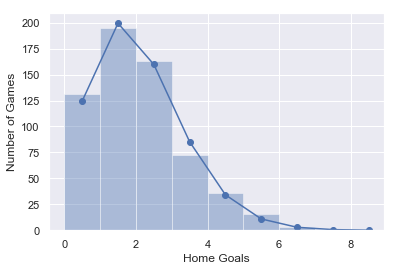

In [18]:
sns.distplot(matches.match_hometeam_score, kde=False, bins = 8)
plt.xlabel("Home Goals")
plt.ylabel("Number of Games")
mlest = matches.match_hometeam_score.mean()
k = np.arange(matches.match_hometeam_score.max()+1)

plt.plot(k+0.5, poisson.pmf(k, mlest)*len(matches.match_hometeam_score), 'bo-')

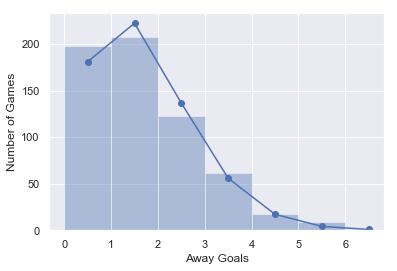

In [19]:
sns.distplot(matches.match_awayteam_score, kde=False, bins = 6)
plt.xlabel("Away Goals")
plt.ylabel("Number of Games")
k = np.arange(matches.match_awayteam_score.max()+1) # observed values for poisson
mean = matches.match_awayteam_score.mean() # mean values of observations

plt.plot(k+0.5,
         poisson.pmf(k, mean)*len(matches.match_awayteam_score),
         'bo-',
         alpha=1)

Text(0, 0.5, 'Number of Games')

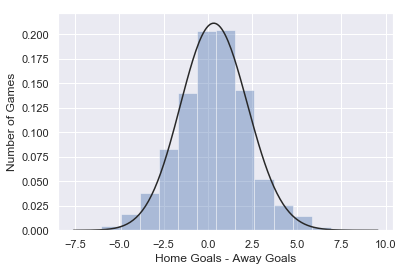

In [20]:
sns.distplot(matches.match_hometeam_score - matches.match_awayteam_score,
             kde=False, bins = 13, fit=gamma)
plt.xlabel("Home Goals - Away Goals")
plt.ylabel("Number of Games")

In [21]:
print('Mean of home_score - away_score is {}'.format((matches.match_hometeam_score - matches.match_awayteam_score).mean()))
print('Std of home_score - away_score is {}'.format((matches.match_hometeam_score - matches.match_awayteam_score).std()))

Mean of home_score - away_score is 0.3737864077669903
Std of home_score - away_score is 1.889429497135252


## 2)


In [22]:
print('Number of columns of bets data is {}'.format(len(bets)))
print('Number of columns of bets data whose bettype' +
      'starts with odd (like odd_1 or odd_x2) is {}'
      .format(len(bets[bets['variable'].str.startswith('odd')])))
print('Number of columns of bets data whose bettype ' +
      'starts with odd and of length 5 (like odd_1 or odd_2 or odd_x) is {}'
      .format(len(bets[(bets['variable'].str.startswith('odd')) & (bets['variable'].str.len() == 5)])))

Number of columns of bets data is 2114743
Number of columns of bets data whose bettypestarts with odd (like odd_1 or odd_x2) is 675034
Number of columns of bets data whose bettype starts with odd and of length 5 (like odd_1 or odd_2 or odd_x) is 417264


In [23]:
bets = bets[(bets['variable'].str.startswith('odd')) & (bets['variable'].str.len() == 5)]

In [24]:
bets.head()

,match_id,odd_bookmakers,odd_epoch,variable,value,timestamp
0,146845,BetOlimp,1486301854,odd_1,1.96,2017-02-05 16:37:34
1,151780,10Bet,1486314920,odd_1,2.15,2017-02-05 20:15:20
2,151780,18bet,1486314920,odd_1,2.17,2017-02-05 20:15:20
3,151780,1xBet,1486314920,odd_1,2.20,2017-02-05 20:15:20
4,151780,5Dimes,1486314920,odd_1,2.23,2017-02-05 20:15:20


In [25]:
# pivoting bets data to see the changes with time easily and see the odds in a single row for each match - bookmaker - timestamp
bets_pivoted = bets.pivot_table(index=['match_id', 'odd_bookmakers', 'timestamp'],
                        columns='variable',
                        values='value').reset_index()
bets_pivoted.head()

variable,match_id,odd_bookmakers,timestamp,odd_1,odd_2,odd_x
0,145899,10Bet,2017-03-12 11:03:01,6.75,1.29,5.25
1,145899,188BET,2017-03-12 11:03:01,4.95,1.43,4.60
2,145899,18bet,2017-03-12 11:03:01,5.35,1.43,4.30
3,145899,1xBet,2017-03-12 11:03:01,6.45,1.49,4.76
4,145899,888sport,2017-03-12 11:03:01,7.00,1.35,5.00


In [26]:
print(len(bets))
print(len(bets_pivoted) * 3)

417264
417264


In [27]:
# we need to remove these illogical observations
bets_pivoted[(bets_pivoted['odd_1'] <= 1) |
             (bets_pivoted['odd_x'] <= 1) |
             (bets_pivoted['odd_2'] <= 1)]

variable,match_id,odd_bookmakers,timestamp,odd_1,odd_2,odd_x
134455,277627,bet365,2019-07-30 10:17:18,0.0,1.9,1.9
134456,277627,bet365.it,2019-07-30 10:17:18,0.0,1.9,1.9


In [28]:
bets_pivoted = bets_pivoted[(bets_pivoted['odd_1'] > 1) &
                            (bets_pivoted['odd_x'] > 1) &
                            (bets_pivoted['odd_2'] > 1)]

In [29]:
# Since bets are changing by time, I will use final odds announced by bookmakers
# by assuming they are correcting their odds somehow
final_bets = bets_pivoted.groupby(['match_id', 'odd_bookmakers'], as_index=False).last()
final_bets.head()

variable,match_id,odd_bookmakers,timestamp,odd_1,odd_2,odd_x
0,145899,10Bet,2017-03-12 11:03:01,6.75,1.29,5.25
1,145899,188BET,2017-03-12 11:03:01,4.95,1.43,4.60
2,145899,18bet,2017-03-12 11:03:01,5.35,1.43,4.30
3,145899,1xBet,2017-03-12 11:03:01,6.45,1.49,4.76
4,145899,888sport,2017-03-12 11:03:01,7.00,1.35,5.00


In [30]:
for cols in ['odd_1', 'odd_x', 'odd_2']:
  final_bets['prob_'+cols] = 1 / final_bets[cols]
final_bets['total'] = final_bets['prob_odd_1'] + final_bets['prob_odd_x'] + final_bets['prob_odd_2']
for cols in ['odd_1', 'odd_x', 'odd_2']:
  final_bets['norm_prob_'+cols] = final_bets['prob_'+cols] / final_bets['total']

In [31]:
matches['result'] = np.where(matches.match_hometeam_score > matches.match_awayteam_score, 1, 0)
matches['result'] = np.where(matches.match_hometeam_score < matches.match_awayteam_score, 2, matches.result)

In [32]:
final_bets = final_bets.merge(matches[['match_id', 'result']], on='match_id')

In [55]:

bins = 10
slices = np.linspace(-1, 1, bins+1, True).astype(np.float)
slices


array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [56]:
# TODO: do not assign on the lower limits
def convert_to_bin(num):
  return min([round(slices[i-1], 2) for i,x in enumerate(slices) if num <= x])

In [ ]:
final_bets = final_bets[final_bets['odd_bookmakers'].isin(['10Bet', '188BET', '1xBet', 'Betsson'])]
final_bets['diff'] = final_bets['norm_prob_odd_1'] - final_bets['norm_prob_odd_2']
final_bets['bins'] = final_bets['diff'].apply(lambda x: convert_to_bin(x))

In [ ]:
match_bins = final_bets.groupby(['bins'], as_index=False)[['match_id']].count()
match_bins

In [ ]:
draws = final_bets[final_bets['result'] == 0].groupby(['bins'], as_index=False)[['match_id']].count()
draws

In [ ]:
match_bins = match_bins.merge(draws, on='bins', how='outer').fillna(0)
match_bins['draw_ratio'] = match_bins['match_id_y'] / match_bins['match_id_x']
match_bins

In [ ]:
ax = sns.scatterplot(x="diff", y="norm_prob_odd_x",
                     sizes=(10, 200),
                     data=final_bets)
plt.plot(match_bins.bins,
         match_bins.draw_ratio,
         'ro-',
         alpha=1)

In [ ]:
# '10Bet', '188BET', '1xBet', 'Betsson'
ax = sns.scatterplot(x="diff", y="norm_prob_odd_x",
                     sizes=(10, 200),
                     data=final_bets[final_bets['odd_bookmakers'] == '188BET'])
plt.plot(match_bins.bins,
         match_bins.draw_ratio,
         'ro-',
         alpha=1)

In [ ]:
# '10Bet', '188BET', '1xBet', 'Betsson'
ax = sns.scatterplot(x="diff", y="norm_prob_odd_x",
                     sizes=(10, 200),
                     data=final_bets[final_bets['odd_bookmakers'] == '1xBet'])
plt.plot(match_bins.bins,
         match_bins.draw_ratio,
         'ro-',
         alpha=1)

In [ ]:
avg_result = final_bets.groupby('bins', as_index=False)[['norm_prob_odd_x']].mean()

In [ ]:
# '10Bet', '188BET', '1xBet', 'Betsson'
ax = sns.scatterplot(x="diff", y="norm_prob_odd_x",
                     sizes=(10, 200),
                     data=final_bets[final_bets['odd_bookmakers'] == '188BET'])
plt.plot(match_bins.bins,
         match_bins.draw_ratio,
         'ro-',
         alpha=1)
plt.plot(avg_result.bins,
         avg_result.norm_prob_odd_x,
         'go-',
         alpha=1)